In [3]:
import keras
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

Using TensorFlow backend.


In [4]:
#Load data and normalize it
root_dir = "."
train_data = pd.read_csv(root_dir + "/Kannada-MNIST/train.csv")
train_labels = train_data['label'].to_numpy()
train_pics = train_data.iloc[:,1:].to_numpy().reshape(-1,28,28,1)/255

val_data = pd.read_csv(root_dir + "/Kannada-MNIST/Dig-MNIST.csv")
val_labels = val_data['label'].to_numpy()
val_pics = val_data.iloc[:,1:].to_numpy().reshape(-1,28,28,1)/255



## In order to see the distribution of the classes, histogram of the data is ploted. Histogram shows that classes are distributed evenly in the training data. There might be no need to balance the classes.
   

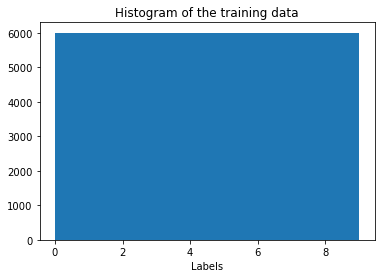

In [5]:
plt.figure(1)
plt.hist(train_labels, bins = 10)
plt.title("Histogram of the training data")
plt.xlabel("Labels")
plt.show()


## Plot an example data point to make sure that data is loaded correctly.

(60000, 28, 28, 1) (10240, 28, 28, 1)


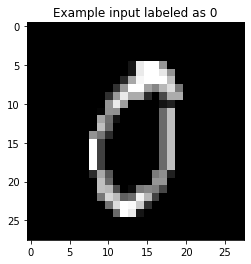

In [6]:
print(train_pics.shape, val_pics.shape)
plt.figure(2)
plt.imshow(train_pics[0].reshape(28,28), cmap = "gray")
plt.title(f"Example input labeled as {train_labels[0]}")
plt.show()

## This function will be called each batch when inserting data into model. It rotates, zooms and shifts the image randomly. Data augmentation increases the flexibility of the model.

In [5]:
#Data augmentation for training, modify data while training to increase generalization ability of the model
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1)

## After every 2 convolution layer; 1 batch normalization, max pooling and dropout layers are added. Since data has low resolution, padding is set ot 'same'. In order to avoid overfitting dropout ratios are adjusted accordingly. Batch normalization layers are used to handle vanishing and exploding gradients problem. Max pooling layer extracts the most important features in the data. Fully connected layer sizes and counts are fine tuned to have a better result. Final fc layer has a softmax activation function to output a distribution over the class labels.

In [6]:
#Construct the model
model = keras.Sequential([
    layers.Input(shape=(28,28,1)),
    layers.Conv2D(32, 5, padding='same', activation='relu', name='conv1'),
    layers.Conv2D(32, 5, padding='same', activation='relu', name='conv2'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    
    layers.Conv2D(32, 3, padding='same', activation='relu', name='conv3'),
    layers.Conv2D(32, 3, padding='same', activation='relu', name='conv4'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    
    layers.Conv2D(64, 3, padding='same', activation='relu', name='conv5'),
    layers.Conv2D(64, 3, padding='same', activation='relu', name='conv6'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(10, activation='softmax')
])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 28, 28, 32)        25632     
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 14, 14, 32)        9248      
_________________________________________________________________
conv4 (Conv2D)               (None, 14, 14, 32)        9

## Since this is a multi class classification problem, categorical cross-entropy loss is used. The model is evaluated based on accuracy.

In [8]:
#Adam optimizer performs well on computer vision tasks
model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss = keras.losses.SparseCategoricalCrossentropy(), metrics = ['accuracy'])
batch_size = 64
epochs = 20
#Validate model performance
log = model.fit(datagen.flow(train_pics,train_labels, batch_size=batch_size),
                steps_per_epoch=len(train_data)/batch_size,
                epochs=epochs,verbose=1, validation_data=(val_pics,val_labels))

Epoch 1/20
938/937 [==============================] - 20s 22ms/step - loss: 0.7426 - accuracy: 0.7439 - val_loss: 0.9592 - val_accuracy: 0.7717
Epoch 2/20
938/937 [==============================] - 18s 19ms/step - loss: 0.1561 - accuracy: 0.9579 - val_loss: 0.8075 - val_accuracy: 0.8298
Epoch 3/20
938/937 [==============================] - 18s 19ms/step - loss: 0.1080 - accuracy: 0.9718 - val_loss: 0.9470 - val_accuracy: 0.8119
Epoch 4/20
938/937 [==============================] - 18s 19ms/step - loss: 0.0938 - accuracy: 0.9763 - val_loss: 0.8248 - val_accuracy: 0.8337
Epoch 5/20
938/937 [==============================] - 18s 19ms/step - loss: 0.0767 - accuracy: 0.9806 - val_loss: 0.6460 - val_accuracy: 0.8752
Epoch 6/20
938/937 [==============================] - 18s 19ms/step - loss: 0.0785 - accuracy: 0.9806 - val_loss: 0.8646 - val_accuracy: 0.8394
Epoch 7/20
938/937 [==============================] - 18s 19ms/step - loss: 0.0645 - accuracy: 0.9838 - val_loss: 0.9569 - val_accuracy:

## Learning curve shows that model has acceptible accuracy on validation data.

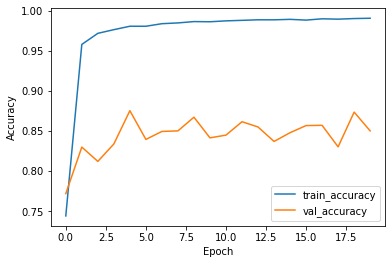

In [9]:
#Plot learning curve
plt.figure(3)
plt.plot(log.history['accuracy'],label = 'train_accuracy')
plt.plot(log.history['val_accuracy'],label = 'val_accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show();

## Accuracy is not always an indicator of a good model. Therefore confusion matrix is plotted to show that true predictions are distributed evenly. Also we can see which class pairs classified worse.

Text(0.5, 1.0, 'Confusion Matrix')

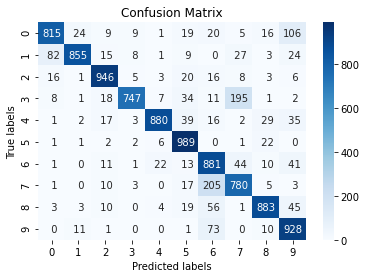

In [10]:
#Plot confusion matrix
y_valid = model.predict(val_pics)
y_valid = np.argmax(y_valid, axis=1)
conf_matrix = confusion_matrix(val_labels, y_valid)
ax = plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax=ax, cmap='Blues', fmt='3d')
#labels, title
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

## After validating the performance of the model, the model is prepared to train on all the avaliable data. Utilizing all the avaliable data is important before testing the model.

In [11]:
#Merge training and validation data for the final training
merged_pics = np.vstack((train_pics,val_pics))
merged_label =  np.hstack((train_labels,val_labels))

In [12]:
#Train with all the available data
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss = keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['accuracy'])
log = model.fit(datagen.flow(merged_pics,merged_label, batch_size=batch_size), 
                steps_per_epoch=len(train_data)/batch_size,
                epochs=epochs,verbose=2)

Epoch 1/20
938/937 - 16s - loss: 0.1157 - accuracy: 0.9722
Epoch 2/20
938/937 - 16s - loss: 0.0883 - accuracy: 0.9777
Epoch 3/20
938/937 - 16s - loss: 0.0829 - accuracy: 0.9781
Epoch 4/20
938/937 - 16s - loss: 0.0747 - accuracy: 0.9802
Epoch 5/20
938/937 - 16s - loss: 0.0759 - accuracy: 0.9806
Epoch 6/20
938/937 - 17s - loss: 0.0739 - accuracy: 0.9805
Epoch 7/20
938/937 - 16s - loss: 0.0688 - accuracy: 0.9825
Epoch 8/20
938/937 - 16s - loss: 0.0657 - accuracy: 0.9834
Epoch 9/20
938/937 - 16s - loss: 0.0677 - accuracy: 0.9822
Epoch 10/20
938/937 - 16s - loss: 0.0620 - accuracy: 0.9840
Epoch 11/20
938/937 - 16s - loss: 0.0619 - accuracy: 0.9830
Epoch 12/20
938/937 - 16s - loss: 0.0567 - accuracy: 0.9851
Epoch 13/20
938/937 - 16s - loss: 0.0607 - accuracy: 0.9839
Epoch 14/20
938/937 - 16s - loss: 0.0586 - accuracy: 0.9845
Epoch 15/20
938/937 - 16s - loss: 0.0570 - accuracy: 0.9851
Epoch 16/20
938/937 - 16s - loss: 0.0552 - accuracy: 0.9853
Epoch 17/20
938/937 - 16s - loss: 0.0555 - accura

In [13]:
#Load test data
test_data = pd.read_csv(root_dir + "/Kannada-MNIST/test.csv")
print(test_data.shape)
test_id = np.array(test_data.index)
test_pics = test_data.iloc[:,1:].to_numpy().reshape(-1,28,28,1)/255

(5000, 785)


In [14]:
#Get predictions for the test data
test_prediction = model.predict(test_pics)
test_prediction = np.argmax(test_prediction, axis = 1)
res = pd.DataFrame(np.concatenate([test_id[:, np.newaxis], test_prediction[:,np.newaxis]], axis=1),
                   columns=["id", "label"])

In [15]:
res

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7
...,...,...
4995,4995,1
4996,4996,1
4997,4997,1
4998,4998,6
